In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
import pandas as pd

In [3]:
#Importing necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import StratifiedKFold,train_test_split, KFold
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LinearRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

In [4]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/Competition\ notebook

/content/drive/My Drive/Colab Notebooks/Competition notebook


In [5]:
#Loading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('SampleSubmission.csv')

EDA

In [6]:
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0


In [7]:
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,293563.000000,293563.000000,293628.000000,293628.000000,297177.000000
mean,40.751195,38.183018,23.316554,78.653623,0.371072
std,28.526182,28.647761,3.836971,14.772725,0.483092
min,-9.450000,-9.700000,16.700000,27.000000,0.000000
25%,22.430000,19.520000,20.400000,68.000000,0.000000
50%,36.470000,33.720000,21.900000,84.000000,0.000000
75%,49.420000,47.570000,26.300000,91.000000,1.000000
max,997.960000,997.260000,34.900000,99.000000,1.000000


In [8]:
test.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
count,127361.000000,127361.000000,39271.000000,39271.000000
mean,42.795356,43.958427,23.683838,72.215834
std,27.838730,28.260335,3.725563,18.078569
min,1.230000,0.780000,16.900000,28.000000
25%,24.670000,25.580000,20.900000,58.000000
50%,39.770000,39.880000,22.500000,78.000000
75%,52.030000,52.830000,26.500000,88.000000
max,927.780000,894.750000,34.000000,97.000000


In [9]:
train.isna().sum()

ID                      0
Datetime                0
Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          3549
Relative_Humidity    3549
Offset_fault            0
dtype: int64

In [10]:
test.isna().sum()

ID                       0
Datetime                 0
Sensor1_PM2.5            0
Sensor2_PM2.5            0
Temperature          88090
Relative_Humidity    88090
dtype: int64

In [ ]:
#I will drop all where Sensor1_PM2.5 and Sensor2 is na in the train
#because in test no missing in sensor1 and 2

In [11]:
train['Offset_fault'].value_counts()

0    186903
1    110274
Name: Offset_fault, dtype: int64

In [12]:
(1542/110274)*100
#just one 1% of the 1s

1.3983350563142716

In [13]:
train[(train['Sensor1_PM2.5'].isna()) & (train['Sensor2_PM2.5'].isna())]['Offset_fault'].value_counts()

0    2072
1    1542
Name: Offset_fault, dtype: int64

In [14]:
# (train['Sensor1_PM2.5'].isna()) & (train['Sensor2_PM2.5'].isna())

In [ ]:
# THis give the rows without na in both Sensor1 and 2
# train = train[~((train['Sensor1_PM2.5'].isna()) & (train['Sensor2_PM2.5'].isna()))]

In [15]:
#the new train and there is still missng in the temperature and relative_hum
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,293563.000000,293563.000000,293628.000000,293628.000000,297177.000000
mean,40.751195,38.183018,23.316554,78.653623,0.371072
std,28.526182,28.647761,3.836971,14.772725,0.483092
min,-9.450000,-9.700000,16.700000,27.000000,0.000000
25%,22.430000,19.520000,20.400000,68.000000,0.000000
50%,36.470000,33.720000,21.900000,84.000000,0.000000
75%,49.420000,47.570000,26.300000,91.000000,1.000000
max,997.960000,997.260000,34.900000,99.000000,1.000000


In [16]:
#fill missing in with mean - std
temp_fill = train['Temperature'].mean()
rel_fill = train['Relative_Humidity'].mean()

train['Temperature'] = train['Temperature'].fillna(temp_fill)
train['Relative_Humidity'] = train['Relative_Humidity'].fillna(rel_fill)
train['Sensor1_PM2.5'] = train['Sensor1_PM2.5'].fillna(42)
train['Sensor2_PM2.5'] = train['Sensor2_PM2.5'].fillna(43)

In [17]:
temp_fill, rel_fill

(23.31655359842922, 78.65362295148964)

In [18]:
#everything is settled
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,297177.000000,297177.000000,297177.000000,297177.000000,297177.000000
mean,40.766382,38.241598,23.316554,78.653623,0.371072
std,28.352526,28.477928,3.813991,14.684249,0.483092
min,-9.450000,-9.700000,16.700000,27.000000,0.000000
25%,22.650000,19.700000,20.400000,68.000000,0.000000
50%,36.770000,34.020000,22.000000,83.000000,0.000000
75%,49.220000,47.380000,26.300000,91.000000,1.000000
max,997.960000,997.260000,34.900000,99.000000,1.000000


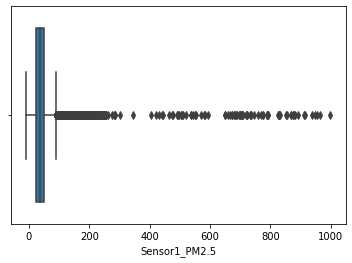

In [19]:
sns.boxplot(train['Sensor1_PM2.5'])

In [ ]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["Offset_fault"])
plt.title('Target variable distribution')
plt.show()


Feature Engineering

In [ ]:
pd.to_datetime("today") #Timestamp('2022-03-19 11:01:18.751351')

Timestamp('2022-03-19 13:46:50.013044')

In [20]:
train['datediff'] =(pd.to_datetime("2022-03-19 11:01:18.751351") - pd.to_datetime(train['Datetime'])).dt.days
train['monthdiff'] = train['datediff'] / 30
train['weekdiff'] = train['datediff'] / 7

In [21]:
train['datediff']

0         136
1         130
2         132
3          76
4         133
         ... 
297172    119
297173    117
297174    134
297175    115
297176    116
Name: datediff, Length: 297177, dtype: int64

In [22]:
train['diffsensor'] = train['Sensor1_PM2.5'] - train['Sensor2_PM2.5']
train['sensormean'] = (train['Sensor1_PM2.5'] + train['Sensor2_PM2.5'])/2

In [23]:
# Extract day, month and year from the Datetime column
train['Datetime_day'] = pd.to_datetime(train['Datetime']).dt.day
train['Datetime_month'] = pd.to_datetime(train['Datetime']).dt.month

In [24]:
#more features
train['sensordiv'] = train['Sensor1_PM2.5'] / train['Sensor2_PM2.5']
train['tempsensor'] = train['Sensor1_PM2.5'] / train['Temperature']
train['relsensor'] = train['Sensor2_PM2.5'] / train['Relative_Humidity']
train['temp/hum'] = train['Relative_Humidity']/train['Temperature']
train['temp/day'] = train['Temperature'] / train['Datetime_day']

In [25]:
train['tarencod'] = round(train.groupby("Datetime_month")['Temperature'].transform('std'), ndigits= 2)
train['tarencodday'] = round(train.groupby("Datetime_day")["Temperature"].transform("std"), ndigits = 2)

In [26]:
# Preview engineered train set
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,datediff,monthdiff,weekdiff,...,sensormean,Datetime_day,Datetime_month,sensordiv,tempsensor,relsensor,temp/hum,temp/day,tarencod,tarencodday
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0,136,4.533333,19.428571,...,51.050,3,11,1.061793,3.021839,0.515833,5.517241,5.800000,3.79,3.73
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0,130,4.333333,18.571429,...,34.325,8,11,1.055389,1.410000,0.445333,3.000000,3.125000,3.79,3.70
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0,132,4.400000,18.857143,...,21.340,7,11,0.816170,0.770281,0.313333,3.012048,3.557143,3.79,3.48
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0,76,2.533333,10.857143,...,17.440,1,1,1.253230,0.779116,0.221143,2.811245,24.900000,4.25,2.98
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0,133,4.433333,19.000000,...,36.535,5,11,1.101524,1.832536,0.390674,4.258373,4.180000,3.79,4.22


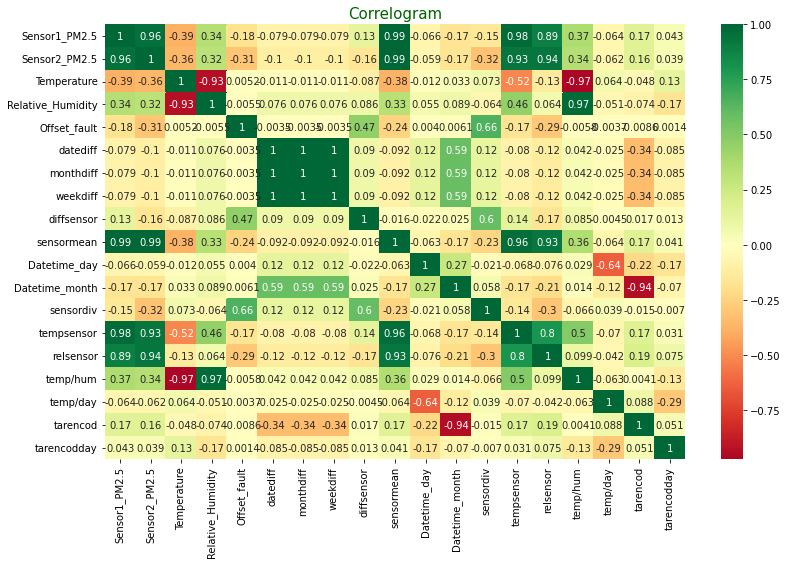

In [27]:
# Quantify correlations
corr = train.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [28]:
train.columns

Index(['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature',
       'Relative_Humidity', 'Offset_fault', 'datediff', 'monthdiff',
       'weekdiff', 'diffsensor', 'sensormean', 'Datetime_day',
       'Datetime_month', 'sensordiv', 'tempsensor', 'relsensor', 'temp/hum',
       'temp/day', 'tarencod', 'tarencodday'],
      dtype='object')

Test Data

In [29]:
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.6,82.0
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.7,80.0


In [30]:
#fill missing in with mean - std
temp_fill = test['Temperature'].mean() 
rel_fill = test['Relative_Humidity'].mean()
test['Temperature'] = test['Temperature'].fillna(temp_fill)
test['Relative_Humidity'] = test['Relative_Humidity'].fillna(rel_fill)

In [31]:
test['datediff'] =(pd.to_datetime("2022-03-19 11:01:18.751351") - pd.to_datetime(test['Datetime'])).dt.days
test['monthdiff'] = test['datediff'] / 30
test['weekdiff'] = test['datediff'] / 7

In [32]:
test['diffsensor'] = test['Sensor1_PM2.5'] - test['Sensor2_PM2.5']
test['sensormean'] = (test['Sensor1_PM2.5'] + test['Sensor2_PM2.5'])/2

In [33]:
# Extract day, month and year from the Datetime column
test['Datetime_day'] = pd.to_datetime(test['Datetime']).dt.day
test['Datetime_month'] = pd.to_datetime(test['Datetime']).dt.month

In [34]:
test['sensordiv'] = test['Sensor1_PM2.5'] / test['Sensor2_PM2.5']
test['tempsensor'] = test['Sensor1_PM2.5'] / test['Temperature']
test['relsensor'] = test['Sensor2_PM2.5'] / test['Relative_Humidity']
test['temp/hum'] = test['Relative_Humidity']/test['Temperature']
test['temp/day'] = test['Temperature'] / test['Datetime_day']

In [35]:
test['tarencod'] = round(test.groupby("Datetime_month")['Temperature'].transform('std'), ndigits= 2)
test['tarencodday'] = round(test.groupby("Datetime_day")["Temperature"].transform("std"), ndigits = 2)

In [36]:
# Preview engineered test set
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,datediff,monthdiff,weekdiff,diffsensor,sensormean,Datetime_day,Datetime_month,sensordiv,tempsensor,relsensor,temp/hum,temp/day,tarencod,tarencodday
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.200000,56.000000,50,1.666667,7.142857,-24.03,102.765,28,1,0.790643,4.087838,2.049643,2.522523,0.792857,3.96,2.31
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,23.683838,72.215834,30,1.000000,4.285714,3.85,54.105,16,2,1.073783,2.365748,0.722556,3.049161,1.480240,1.57,0.00
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.100000,63.000000,53,1.766667,7.571429,40.62,367.040,24,1,1.117152,13.784698,5.503651,2.241993,1.170833,3.96,2.48
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.600000,82.000000,47,1.566667,6.714286,-20.68,73.510,31,1,0.753369,2.924537,1.022561,3.796296,0.696774,3.96,0.96
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.700000,80.000000,47,1.566667,6.714286,16.16,61.150,31,1,1.304503,3.049780,0.663375,3.524229,0.732258,3.96,0.96


In [37]:
train.columns

Index(['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature',
       'Relative_Humidity', 'Offset_fault', 'datediff', 'monthdiff',
       'weekdiff', 'diffsensor', 'sensormean', 'Datetime_day',
       'Datetime_month', 'sensordiv', 'tempsensor', 'relsensor', 'temp/hum',
       'temp/day', 'tarencod', 'tarencodday'],
      dtype='object')

In [38]:
test.columns

Index(['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature',
       'Relative_Humidity', 'datediff', 'monthdiff', 'weekdiff', 'diffsensor',
       'sensormean', 'Datetime_day', 'Datetime_month', 'sensordiv',
       'tempsensor', 'relsensor', 'temp/hum', 'temp/day', 'tarencod',
       'tarencodday'],
      dtype='object')

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

Baseline Model

In [106]:
# feats = ['Temperature', 'Relative_Humidity', 'datediff',
#          'meansensor', 'Datetime_day', 'Datetime_month']
feats = ['Temperature', 'Relative_Humidity', 'datediff', 'monthdiff',
       'weekdiff', 'diffsensor', 'sensormean', 'Datetime_day',
       'Datetime_month', 'sensordiv', 'tempsensor', 'relsensor', 'temp/hum',
       'temp/day', 'tarencod', 'tarencodday']

X = train.fillna(0)
X = X[feats]

# X = train[feats]
y = train.Offset_fault

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
clf = RandomForestClassifier(max_depth = 10, random_state = 0)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
# 0.944545393364291

Accuracy score: 0.9460371940686901


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     55966
           1       0.93      0.93      0.93     33188

    accuracy                           0.95     89154
   macro avg       0.94      0.94      0.94     89154
weighted avg       0.95      0.95      0.95     89154



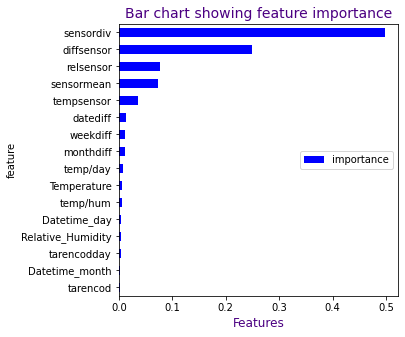

In [107]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (5, 5), color = 'blue')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [108]:
a = clf.predict(test[feats].fillna(0))
submission['Offset_fault'] = a
submission.to_csv('rfcgrow.csv', index = False)
a.sum()
# 31986

33982

In [ ]:
feats = ['Temperature', 'Relative_Humidity', 'datediff', 'monthdiff',
       'weekdiff', 'diffsensor', 'sensormean', 'Datetime_day',
       'Datetime_month', 'sensordiv', 'tempsensor', 'relsensor', 'temp/hum',
       'temp/day', 'tarencod', 'tarencodday']

X = train[feats]
y = train.Offset_fault


from catboost import CatBoostClassifier
errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
fold=StratifiedKFold(n_splits=10)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = CatBoostClassifier(n_estimators=800,eval_metric='Accuracy',od_wait=200, learning_rate=0.2,
                              bootstrap_type='Bernoulli',metric_period=100,max_depth = 10,
                     use_best_model=True)
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=100,)
    preds=m2.predict(X_test)
    print("Accuracy: ",(accuracy_score(y_test,preds)))
    errcb2.append((accuracy_score(y_test,preds)))
    p2 = m2.predict(test[feats])
    y_pred_totcb2.append(p2)
np.mean(errcb2)

0:	learn: 0.9220180	test: 0.9220180	test1: 0.9227741	best: 0.9227741 (0)	total: 421ms	remaining: 5m 36s
100:	learn: 0.9616427	test: 0.9616427	test1: 0.9587792	best: 0.9587792 (100)	total: 19.1s	remaining: 2m 12s
200:	learn: 0.9702796	test: 0.9702796	test1: 0.9644660	best: 0.9645669 (195)	total: 35.7s	remaining: 1m 46s
300:	learn: 0.9756748	test: 0.9756748	test1: 0.9667205	best: 0.9667205 (286)	total: 52.3s	remaining: 1m 26s
400:	learn: 0.9793576	test: 0.9793576	test1: 0.9673935	best: 0.9676963 (391)	total: 1m 8s	remaining: 1m 8s
500:	learn: 0.9826216	test: 0.9826216	test1: 0.9684030	best: 0.9684366 (481)	total: 1m 25s	remaining: 51s
600:	learn: 0.9852650	test: 0.9852650	test1: 0.9689414	best: 0.9690087 (551)	total: 1m 42s	remaining: 33.8s
700:	learn: 0.9875345	test: 0.9875345	test1: 0.9693788	best: 0.9699172 (657)	total: 1m 59s	remaining: 16.9s
799:	learn: 0.9893442	test: 0.9893442	test1: 0.9694125	best: 0.9699172 (657)	total: 2m 15s	remaining: 0us

bestTest = 0.9699172219
bestIteratio

0:	learn: 0.9207467	test: 0.9207467	test1: 0.9193418	best: 0.9193418 (0)	total: 194ms	remaining: 2m 34s
100:	learn: 0.9620540	test: 0.9620540	test1: 0.9578707	best: 0.9579716 (96)	total: 16.8s	remaining: 1m 56s
200:	learn: 0.9706086	test: 0.9706086	test1: 0.9632546	best: 0.9632546 (200)	total: 33.5s	remaining: 1m 39s
300:	learn: 0.9759178	test: 0.9759178	test1: 0.9652736	best: 0.9652736 (289)	total: 50.2s	remaining: 1m 23s
400:	learn: 0.9799296	test: 0.9799296	test1: 0.9667205	best: 0.9668215 (389)	total: 1m 6s	remaining: 1m 6s
500:	learn: 0.9830105	test: 0.9830105	test1: 0.9671243	best: 0.9673262 (427)	total: 1m 24s	remaining: 50.2s
600:	learn: 0.9856763	test: 0.9856763	test1: 0.9670234	best: 0.9673262 (427)	total: 1m 46s	remaining: 35.2s
700:	learn: 0.9879122	test: 0.9879122	test1: 0.9673598	best: 0.9676963 (666)	total: 2m 2s	remaining: 17.4s
799:	learn: 0.9896732	test: 0.9896732	test1: 0.9678646	best: 0.9679655 (780)	total: 2m 19s	remaining: 0us

bestTest = 0.9679655428
bestIteratio

0:	learn: 0.9204439	test: 0.9204439	test1: 0.9228077	best: 0.9228077 (0)	total: 196ms	remaining: 2m 36s
100:	learn: 0.9620465	test: 0.9620465	test1: 0.9600915	best: 0.9600915 (100)	total: 16.9s	remaining: 1m 56s
200:	learn: 0.9706011	test: 0.9706011	test1: 0.9640285	best: 0.9641968 (194)	total: 33.6s	remaining: 1m 39s
300:	learn: 0.9760412	test: 0.9760412	test1: 0.9665186	best: 0.9665186 (300)	total: 50.2s	remaining: 1m 23s
400:	learn: 0.9800755	test: 0.9800755	test1: 0.9666869	best: 0.9667878 (358)	total: 1m 6s	remaining: 1m 6s
500:	learn: 0.9827114	test: 0.9827114	test1: 0.9678646	best: 0.9681001 (492)	total: 1m 23s	remaining: 50s
600:	learn: 0.9854221	test: 0.9854221	test1: 0.9686049	best: 0.9686049 (600)	total: 1m 40s	remaining: 33.2s
700:	learn: 0.9876205	test: 0.9876205	test1: 0.9691433	best: 0.9691433 (698)	total: 1m 56s	remaining: 16.5s
799:	learn: 0.9892956	test: 0.9892956	test1: 0.9690087	best: 0.9693115 (756)	total: 2m 13s	remaining: 0us

bestTest = 0.9693115284
bestIteratio

0:	learn: 0.9209038	test: 0.9209038	test1: 0.9178949	best: 0.9178949 (0)	total: 202ms	remaining: 2m 41s
100:	learn: 0.9620839	test: 0.9620839	test1: 0.9579043	best: 0.9579716 (99)	total: 16.9s	remaining: 1m 56s
200:	learn: 0.9706273	test: 0.9706273	test1: 0.9630527	best: 0.9633219 (189)	total: 33.6s	remaining: 1m 40s
300:	learn: 0.9760823	test: 0.9760823	test1: 0.9653409	best: 0.9653409 (300)	total: 50.2s	remaining: 1m 23s
400:	learn: 0.9799222	test: 0.9799222	test1: 0.9657447	best: 0.9659129 (378)	total: 1m 6s	remaining: 1m 6s
500:	learn: 0.9829133	test: 0.9829133	test1: 0.9665523	best: 0.9668888 (469)	total: 1m 23s	remaining: 49.8s
600:	learn: 0.9853510	test: 0.9853510	test1: 0.9678982	best: 0.9679992 (596)	total: 1m 40s	remaining: 33.2s
700:	learn: 0.9876392	test: 0.9876392	test1: 0.9677300	best: 0.9679992 (596)	total: 1m 57s	remaining: 16.5s
799:	learn: 0.9893367	test: 0.9893367	test1: 0.9675954	best: 0.9680328 (788)	total: 2m 13s	remaining: 0us

bestTest = 0.968032842
bestIteratio

0:	learn: 0.9220778	test: 0.9220778	test1: 0.9225722	best: 0.9225722 (0)	total: 193ms	remaining: 2m 34s
100:	learn: 0.9618297	test: 0.9618297	test1: 0.9583081	best: 0.9583081 (100)	total: 17s	remaining: 1m 57s
200:	learn: 0.9705188	test: 0.9705188	test1: 0.9624134	best: 0.9625480 (198)	total: 33.8s	remaining: 1m 40s
300:	learn: 0.9761122	test: 0.9761122	test1: 0.9643650	best: 0.9643650 (300)	total: 50.6s	remaining: 1m 23s
400:	learn: 0.9799035	test: 0.9799035	test1: 0.9656774	best: 0.9657447 (387)	total: 1m 7s	remaining: 1m 7s
500:	learn: 0.9827076	test: 0.9827076	test1: 0.9662494	best: 0.9665186 (488)	total: 1m 24s	remaining: 50.2s
600:	learn: 0.9855230	test: 0.9855230	test1: 0.9667542	best: 0.9668888 (587)	total: 1m 40s	remaining: 33.4s
700:	learn: 0.9875831	test: 0.9875831	test1: 0.9670234	best: 0.9673598 (651)	total: 1m 57s	remaining: 16.6s
799:	learn: 0.9895311	test: 0.9895311	test1: 0.9670570	best: 0.9673935 (740)	total: 2m 13s	remaining: 0us

bestTest = 0.9673934989
bestIteratio

0:	learn: 0.9208888	test: 0.9208888	test1: 0.9191399	best: 0.9191399 (0)	total: 206ms	remaining: 2m 44s
100:	learn: 0.9621774	test: 0.9621774	test1: 0.9576015	best: 0.9576015 (100)	total: 16.9s	remaining: 1m 57s
200:	learn: 0.9707918	test: 0.9707918	test1: 0.9618077	best: 0.9618077 (199)	total: 33.6s	remaining: 1m 40s
300:	learn: 0.9759926	test: 0.9759926	test1: 0.9644996	best: 0.9644996 (300)	total: 50.2s	remaining: 1m 23s
400:	learn: 0.9798511	test: 0.9798511	test1: 0.9661485	best: 0.9661485 (400)	total: 1m 6s	remaining: 1m 6s
500:	learn: 0.9829095	test: 0.9829095	test1: 0.9660812	best: 0.9665186 (482)	total: 1m 23s	remaining: 49.9s
600:	learn: 0.9856539	test: 0.9856539	test1: 0.9665859	best: 0.9667205 (585)	total: 1m 40s	remaining: 33.2s
700:	learn: 0.9874149	test: 0.9874149	test1: 0.9668215	best: 0.9669897 (650)	total: 1m 56s	remaining: 16.5s
799:	learn: 0.9893217	test: 0.9893217	test1: 0.9672589	best: 0.9673262 (777)	total: 2m 13s	remaining: 0us

bestTest = 0.9673261996
bestIterat

0:	learn: 0.9194269	test: 0.9194269	test1: 0.9188371	best: 0.9188371 (0)	total: 204ms	remaining: 2m 42s
100:	learn: 0.9618633	test: 0.9618633	test1: 0.9583081	best: 0.9583081 (100)	total: 16.9s	remaining: 1m 57s
200:	learn: 0.9704291	test: 0.9704291	test1: 0.9641968	best: 0.9641968 (200)	total: 33.7s	remaining: 1m 40s
300:	learn: 0.9759290	test: 0.9759290	test1: 0.9663167	best: 0.9663167 (299)	total: 50.3s	remaining: 1m 23s
400:	learn: 0.9795969	test: 0.9795969	test1: 0.9668215	best: 0.9670907 (394)	total: 1m 7s	remaining: 1m 7s
500:	learn: 0.9827375	test: 0.9827375	test1: 0.9677300	best: 0.9677636 (493)	total: 1m 23s	remaining: 50.1s
600:	learn: 0.9852576	test: 0.9852576	test1: 0.9678982	best: 0.9680328 (581)	total: 1m 40s	remaining: 33.3s
700:	learn: 0.9873177	test: 0.9873177	test1: 0.9681674	best: 0.9683693 (686)	total: 1m 57s	remaining: 16.5s
799:	learn: 0.9893629	test: 0.9893629	test1: 0.9683020	best: 0.9686722 (754)	total: 2m 13s	remaining: 0us

bestTest = 0.9686721852
bestIterat

0:	learn: 0.9235138	test: 0.9235138	test1: 0.9230743	best: 0.9230743 (0)	total: 200ms	remaining: 2m 39s
100:	learn: 0.9617513	test: 0.9617513	test1: 0.9545715	best: 0.9545715 (100)	total: 16.9s	remaining: 1m 56s
200:	learn: 0.9704404	test: 0.9704404	test1: 0.9603930	best: 0.9603930 (200)	total: 33.5s	remaining: 1m 39s
300:	learn: 0.9755851	test: 0.9755851	test1: 0.9628159	best: 0.9630851 (297)	total: 50.1s	remaining: 1m 22s
400:	learn: 0.9792530	test: 0.9792530	test1: 0.9638591	best: 0.9639600 (398)	total: 1m 6s	remaining: 1m 6s
500:	learn: 0.9823637	test: 0.9823637	test1: 0.9646330	best: 0.9650032 (471)	total: 1m 23s	remaining: 49.7s
600:	learn: 0.9847828	test: 0.9847828	test1: 0.9652051	best: 0.9656089 (577)	total: 1m 39s	remaining: 33.1s
700:	learn: 0.9870411	test: 0.9870411	test1: 0.9662146	best: 0.9663156 (675)	total: 1m 56s	remaining: 16.4s
799:	learn: 0.9890825	test: 0.9890825	test1: 0.9667194	best: 0.9667867 (794)	total: 2m 12s	remaining: 0us

bestTest = 0.9667866878
bestIterat

0:	learn: 0.9231250	test: 0.9231250	test1: 0.9230743	best: 0.9230743 (0)	total: 194ms	remaining: 2m 34s
100:	learn: 0.9617176	test: 0.9617176	test1: 0.9573308	best: 0.9574654 (99)	total: 16.8s	remaining: 1m 56s
200:	learn: 0.9704704	test: 0.9704704	test1: 0.9617391	best: 0.9619746 (189)	total: 33.5s	remaining: 1m 39s
300:	learn: 0.9760824	test: 0.9760824	test1: 0.9649359	best: 0.9650032 (299)	total: 50.2s	remaining: 1m 23s
400:	learn: 0.9796755	test: 0.9796755	test1: 0.9664165	best: 0.9664165 (400)	total: 1m 6s	remaining: 1m 6s
500:	learn: 0.9830143	test: 0.9830143	test1: 0.9673924	best: 0.9675607 (490)	total: 1m 23s	remaining: 49.8s
600:	learn: 0.9855530	test: 0.9855530	test1: 0.9672578	best: 0.9678972 (524)	total: 1m 40s	remaining: 33.2s
700:	learn: 0.9873476	test: 0.9873476	test1: 0.9674934	best: 0.9678972 (524)	total: 1m 56s	remaining: 16.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9678971632
bestIteration = 524

Shrink model to first 525 iterations.
Acc

0:	learn: 0.9243737	test: 0.9243737	test1: 0.9232762	best: 0.9232762 (0)	total: 194ms	remaining: 2m 35s
100:	learn: 0.9620018	test: 0.9620018	test1: 0.9583067	best: 0.9583067 (100)	total: 16.8s	remaining: 1m 56s
200:	learn: 0.9704068	test: 0.9704068	test1: 0.9621092	best: 0.9621429 (197)	total: 33.4s	remaining: 1m 39s
300:	learn: 0.9761385	test: 0.9761385	test1: 0.9654743	best: 0.9656089 (290)	total: 49.9s	remaining: 1m 22s
400:	learn: 0.9797016	test: 0.9797016	test1: 0.9668540	best: 0.9672578 (387)	total: 1m 6s	remaining: 1m 6s


In [109]:
# feats = ['Temperature', 'Relative_Humidity', 'datediff',
#          'meansensor', 'Datetime_day', 'Datetime_month']
feats = ['Temperature', 'Relative_Humidity', 'datediff', 'monthdiff',
       'weekdiff', 'diffsensor', 'sensormean', 'Datetime_day',
       'Datetime_month', 'sensordiv', 'tempsensor', 'relsensor', 'temp/hum',
       'temp/day', 'tarencod', 'tarencodday']

X = train.fillna(0)
X = X[feats]

# X = train[feats]
y = train.Offset_fault

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
#max_..10, learn_100
xgb = XGBClassifier(random_state=0, scale_pos_weight = 1.7, max_depth=7, n_estimators= 1000, learning_rate= 0.1 )
xgb.fit(X_train, y_train)

# Making predictions
y_pred = xgb.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
# 0.9579267335172847

[16:27:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score: 0.9649819413598941


              precision    recall  f1-score   support

           0       0.98      0.97      0.97     55966
           1       0.94      0.96      0.95     33188

    accuracy                           0.96     89154
   macro avg       0.96      0.96      0.96     89154
weighted avg       0.97      0.96      0.97     89154



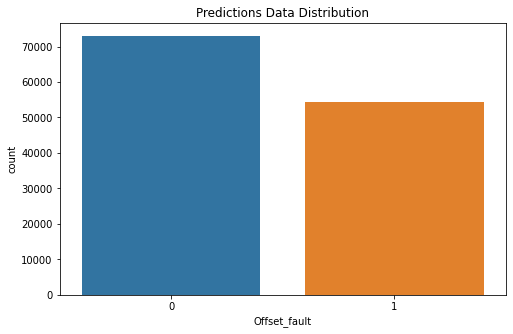

In [110]:
# Make prediction on the test set
test_df = test[feats]
xgb_pred = xgb.predict(test_df)

submission['Offset_fault'] = xgb_pred

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(submission.Offset_fault)
plt.title('Predictions Data Distribution');

In [111]:
submission['Offset_fault'].value_counts()

0    72957
1    54404
Name: Offset_fault, dtype: int64

In [69]:
# Create file
submission.to_csv('xgbouou.csv', index = False)

Other models

In [112]:
# feats = ['Temperature', 'Relative_Humidity', 'datediff',
#          'meansensor', 'Datetime_day', 'Datetime_month']
# feats = ['Sensor1_PM2.5', 'Temperature', 'Relative_Humidity', 'datediff',
#          'diffsensor', 'Datetime_day', 'Datetime_month', 'temp/hum']

# X = train[feats]
# y = train.Offset_fault

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
# max_d..7
cat = CatBoostClassifier(max_depth = 10, random_state = 0, verbose = 0)
cat.fit(X_train, y_train)

# Making predictions
y_pred = cat.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
# 0.9660699463849071

Accuracy score: 0.9659914305583597


              precision    recall  f1-score   support

           0       0.97      0.97      0.97     55966
           1       0.95      0.95      0.95     33188

    accuracy                           0.97     89154
   macro avg       0.96      0.96      0.96     89154
weighted avg       0.97      0.97      0.97     89154



In [113]:
test_df = test[feats]
cat_pred = cat.predict(test_df)
cat_pred.sum()
# submission['Offset_fault'] = predictions
# submission.to_csv('catjorna.csv', index=False)
# submission['Offset_fault'].value_counts()

# 83366
# 1    43995

43961

In [114]:
# from lightgbm.sklearn import LGBMModel
# feats = ['Temperature', 'Relative_Humidity', 'datediff',
#          'meansensor', 'Datetime_day', 'Datetime_month']
# feats = ['Sensor1_PM2.5','Sensor2_PM2.5', 'Temperature', 'Relative_Humidity', 'datediff',
#          'diffsensor', 'Datetime_day', 'Datetime_month', 'temp/hum']

# X = train[feats]
# y = train.Offset_fault

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
ETC = LGBMClassifier(n_estimators = 1000, class_weight = 'balanced')
ETC.fit(X_train, y_train)

# Making predictions
y_pred = ETC.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
#0.9647463938802522

Accuracy score: 0.9647912600668506


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     55966
           1       0.94      0.97      0.95     33188

    accuracy                           0.96     89154
   macro avg       0.96      0.97      0.96     89154
weighted avg       0.97      0.96      0.96     89154



In [115]:
testdf = test[feats]
re = ETC.predict(testdf)
re.sum()

52471

In [81]:
submission['Offset_fault'] = re
submission.to_csv('hmmmlgb.csv', index = False)

In [83]:
b = a + re + predictions

In [116]:
b = re + cat_pred + xgb_pred

In [125]:
b = re + cat_pred + xgb_pred + pd.read_csv('rfclassweightall1.csv')['Offset_fault']

In [130]:
np.where(b/4 >=0.75, 1, 0).sum()

44308

In [129]:
3/4

0.75

In [86]:
np.where(b/3>0.6, 1, 0).sum()

43455

In [122]:
np.where(b/3>0.8, 1, 0).sum()

42014

In [87]:
combo = np.where(b/3>0.6, 1, 0)
submission['Offset_fault'] = combo
submission.to_csv('comboxgb_lgb_rfc.csv', index = False)

In [123]:
combo = np.where(b/3>0.8, 1, 0)
submission['Offset_fault'] = combo
submission.to_csv('comboxgb_lgb_rfc2.csv', index = False)

In [132]:

combo = np.where(b/4 >=0.75, 1, 0)
submission['Offset_fault'] = combo
submission.to_csv('comboxgb_lgb_rfc_highest.csv', index = False)

In [124]:
pd.read_csv('rfclassweightall1.csv')['Offset_fault']

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,1
...,...,...
127356,ID_HNCS9Q2GNCQB,0
127357,ID_GIIQYTE11L3H,1
127358,ID_EC7F1P4GXKCL,0
127359,ID_J64RVG2BRAG0,0
